# Extract DTM file names from HTML table and create polygon vector layer with the tiles' BBs

The German Federal State of North Rhine-Westphalia (NRW or NW) provides wonderful and huge open data on its **[NRW Open Geodata Portal](https://www.opengeodata.nrw.de/produkte/)**.

One of the fantastic data sets is the [**Digital Terrain Model (DTM) tiles of NRW in 1m horizontal resolution**](https://www.opengeodata.nrw.de/produkte/geobasis/hm/dgm1_xyz/dgm1_xyz/). This link provides a table with the filenames and download links of 35860 DTM tiles covering NRW of 1 km² size.

To see on a map where these tiles a squared polygon is created for each tile with shows location and extent of the tiles. The coordinates of the corner of the squares are derived from the filename which contains the lower left corner and the tile size (here: 1000 x 1000 grid points with 1m spacing, yielding 1000 m x 1000 m total tile size).  

Web scraping ([Wikipedia](https://en.wikipedia.org/wiki/Web_scraping)) with [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) is used to extract the DTM filenames from the HTML table listing all the files [here](https://www.opengeodata.nrw.de/produkte/geobasis/hm/dgm1_xyz/dgm1_xyz/).

In [1]:
dtm_url = r"https://www.opengeodata.nrw.de/produkte/geobasis/hm/dgm1_xyz/dgm1_xyz/"

In [24]:
data_dir = r"../data/derived/NRW_DTM_NRW_EPSG_25832_Tiles_BB/"
out_fname = r"NRW_DTM_NRW_EPSG_25832_Tiles_BB.gpkg"

In [9]:
import requests
from bs4 import BeautifulSoup
from shapely.geometry import Polygon
import geopandas as gpd
import os

In [14]:
os.makedirs(data_dir,exist_ok = True)

In [2]:
example = "dgm1_32_280_5652_1_nw.xyz.gz"
example

'dgm1_32_280_5652_1_nw.xyz.gz'

In [3]:
example = "dgm1_32_280_5652_1_nw.xyz.gz"
example.split("_")

['dgm1', '32', '280', '5652', '1', 'nw.xyz.gz']

In [4]:
def points_from_fname(fname, Dx=1000, Dy=1000):
    """
    Usage: [(x_LL,y_LL),(x_UL,y_UL),(x_UR,y_UR),(x_LR,y_LR)]  = points_from_fname(...)
       
    Returns a list of four 2-tuples representing the corner points of a square. 
    Create corner points of the squared bounding box for a NRW DTM tile in ESPG:25832.
    URL of NRW DTM tile collection: https://www.opengeodata.nrw.de/produkte/geobasis/hm/dgm1_xyz/dgm1_xyz/
    The coordinates of the lower left corner are extracted from the filename which is 
    formatted like 'dgm1_32_280_5652_1_nw.xyz.gz'. Filename elements:
    dgm1: name of product with 1x1 m² grid cell size, 32: UTM Zone 32, EPSG:25832, 
    280: Easting in km, 5652: Northing in km, 1: 1m x 1m grid cell size, nw: North Rhine-Wastphalia,
    xyz: ASCII fixed width file format with three columns (easting, northing, elevation), gz: GNU zipped
    """
    
    x_Left  = int(fname.split("_")[2])*1000
    y_Low   = int(fname.split("_")[3])*1000
    x_Right = x_Left + Dx
    y_Up    = y_Low + Dy

    P_LL = (x_Left,y_Low)
    P_UL = (x_Left,y_Up)
    P_UR = (x_Right,y_Up)
    P_LR = (x_Right,y_Low)
    
    return [P_LL, P_UL, P_UR, P_LR]

In [5]:
points_from_fname(example)

[(280000, 5652000), (280000, 5653000), (281000, 5653000), (281000, 5652000)]

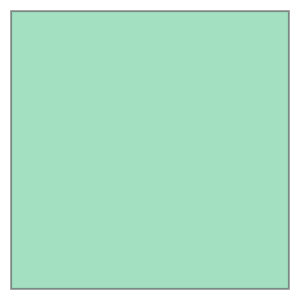

In [7]:
import shapely
shapely.Polygon(points_from_fname(example))

In [10]:
r = requests.get(dtm_url)

soup = BeautifulSoup(r.content, 'html.parser')

/Users/sac/anaconda3/envs/geoinfo/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [17]:
#soup

In [19]:
tag_list = soup.find_all('file')
file_name_list = [tag['name'] for tag in tag_list]
polygon_list = [shapely.Polygon(points_from_fname(file_name)) for file_name in file_name_list]

In [23]:
tag_list = soup.find_all('file')
fname_list = [tag["name"] for tag in tag_list]
geom_list = [Polygon(points_from_fname(fname)) for fname in fname_list]

In [28]:
#tag_list[:10]

In [21]:
# fname: polygon attribute, geometry: polygon geometry 
dic = {'fname': file_name_list, 'geometry': polygon_list}
gdf = gpd.GeoDataFrame(data = dic, crs="EPSG:25832")

In [22]:
print(f"gdf.shape: {gdf.shape}")
gdf.head()

gdf.shape: (35860, 2)


,fname,geometry
0,dgm1_32_280_5652_1_nw.xyz.gz,"POLYGON ((280000.000 5652000.000, 280000.000 5..."
1,dgm1_32_280_5653_1_nw.xyz.gz,"POLYGON ((280000.000 5653000.000, 280000.000 5..."
2,dgm1_32_280_5654_1_nw.xyz.gz,"POLYGON ((280000.000 5654000.000, 280000.000 5..."
3,dgm1_32_280_5655_1_nw.xyz.gz,"POLYGON ((280000.000 5655000.000, 280000.000 5..."
4,dgm1_32_280_5656_1_nw.xyz.gz,"POLYGON ((280000.000 5656000.000, 280000.000 5..."


In [25]:
print(f"Write gdf to file {data_dir + out_fname:s}")
gdf.to_file(data_dir + out_fname, driver = "GPKG") 

Write gdf to file ../data/derived/NRW_DTM_NRW_EPSG_25832_Tiles_BB/NRW_DTM_NRW_EPSG_25832_Tiles_BB.gpkg
